# 1D Convolutional Neural Networks for Text Categorization


In this lab, we will implement a convolutional neural network (CNN) to perform binary movie review classification (positive/negative) using the [Keras](https://keras.io/getting-started/faq/}) library. 

You will recieve an overview of using Keras. It provides an API over TensorFlow, which you worked with in the last lab.

The architecture of the CNN we will develop is described in [CNNs for Sentence Classification (Kim, EMNLP'14)](https://arxiv.org/abs/1408.5882). We will also visualize document embeddings and predictive regions in the input documents, following [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL'15)](https://arxiv.org/pdf/1412.1058.pdf), and first-order derivate saliency maps, following [Visualizing and Understanding Neural Models in NLP (Li et al., NAACL'16)](https://arxiv.org/abs/1506.01066). 



### Reading data and preprocessing
For our experiments, we will use the [sentence polarity dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz). The dataset was collected by Pang and Lee and consists of 5,331 positive and 5,331 negative snippets acquired from Rotten Tomatoes. Snippets were automatically labeled using the labels provided by Rotten Tomatoes. The positive and negative reviews are stored into the `rt-polarity.pos` and `rt-polarity.neg` files, respectively. Let's first read the data.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.utils import np_utils

def load_documents(filename):
    docs =[]

    with open(filename, encoding='utf8', errors='ignore') as f:
        for line in f:
            docs.append(line[:-1])

    return docs

docs   = list()
labels = list()

docs_pos = load_documents('data/rt-polarity.pos')
docs.extend(docs_pos)
labels.extend([1]*len(docs_pos))

docs_neg = load_documents('data/rt-polarity.neg')
docs.extend(docs_neg)
labels.extend([0]*len(docs_neg))

y = np_utils.to_categorical(labels)

print("A positive review:", docs_pos[0])
print('\n')
print("A negative review:", docs_neg[0])

A positive review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 


A negative review: simplistic , silly and tedious . 


Using TensorFlow backend.


The documents that are contained in the dataset have already undergone some preprocessing. Therefore, we will only remove some punctuation marks, diacritics, and non letters, if any. Furthermore, we will represent each document as a list of tokens. Use the ``preprocessing`` function (already implemented) to preprocess the documents.

In [4]:
import re

def clean_str(string):
    string = ''.join(c for c in string if c.isalpha() or c.isnumeric() or c is ' ')
    return string.strip().split()

    
def preprocessing(docs):
    preprocessed_docs = []

    for doc in docs:
        preprocessed_docs.append(clean_str(doc.lower()))

    return preprocessed_docs


processed_docs_pos = preprocessing(docs_pos)
processed_docs_neg = preprocessing(docs_neg)

Subsequently, we will extract the vocabulary of the dataset. We will store the vocabulary in a dictionary where keys are terms and values correspond to indices. Hence, each term will be assigned a unique index. The minimum index will be equal to 1, while the maximum index will be equal to the size of the vocabulary.

In [6]:
def get_vocab(processed_docs):
    vocab = dict()

    for doc in processed_docs:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab) + 1

    return vocab

processed_docs = processed_docs_pos + processed_docs_neg
vocab = get_vocab(processed_docs)
print("Size of the vocabulary:", len(vocab))
print("Index of term 'bad':", vocab["bad"])

Size of the vocabulary: 20473
Index of term 'bad': 1509


Next, we use a set of 300-dimensional word embeddings learned with word2vec on the GoogleNews dataset. The embeddings can be downloaded from https://code.google.com/archive/p/word2vec/, under the section "Pre-trained word and phrase vectors". Using `gensim`, we can extract only the vectors of the words found in our vocabulary. Terms not present in the set of pre-trained words are initialized randomly (uniformly in [−0.25, 0.25]). Before executing the code, set the path for the file that contains the word embeddings.

https://fr.wikipedia.org/wiki/Word_embedding
Le word embedding (« plongement de mots » ou « plongement lexical » en français) est une méthode se focalisant sur l'apprentissage d'une représentation de mots. Cette technique permet de représenter chaque mot d'un dictionnaire par un vecteur de nombres réels correspondant. Ceci facilite notamment l'analyse sémantique des mots. Cette nouvelle représentation a ceci de particulier que les mots apparaissant dans des contextes similaires possèdent des vecteurs correspondants qui sont relativement proches. Par exemple, on pourrait s'attendre à ce que les mots « chien » et « chat » soient représentés par des vecteurs relativement peu distants dans l'espace vectoriel où sont définis ces vecteurs.

https://fr.wikipedia.org/wiki/Word2vec
En intelligence artificielle et en apprentissage machine, Word2vec est un groupe de modèles utilisé pour le plongement lexical) (word embedding).
Ces modèles ont été développés par une équipe de recherche chez Google sous la direction de Tomas Mikolov (en).
Ce sont des réseaux de neurones artificiels à deux couches entraînés pour reconstruire le contexte linguistique des mots.
La méthode est implémentée dans la bibliothèque Python Gensim

In [7]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(fname, vocab):
    embeddings = np.zeros((len(vocab)+1, 300))
    
    model = KeyedVectors.load_word2vec_format(fname, binary=True)
    for word in vocab:
        if word in model:
            embeddings[vocab[word]] = model[word]
        else:
            embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, 300)
    return embeddings

path_to_embeddings = '/Users/acarossio/Documents/GoogleNews-vectors-negative300.bin' # fill in the path
embeddings = load_embeddings(path_to_embeddings, vocab)

We will now calculate the size of the largest document and create a matrix whose rows correspond to documents. Each row contains the indices of the terms appearing in the document and preserves the order of the terms in the document. That is, the first component of a row contains the index of the first term of the corresponding document, the second component contains the index of the second term etc. Documents whose length is shorter than that of the longest document are padded with zeros.

In [8]:
def longest_list(l):
    lengths = [len(m) for m in l]
    return max(lengths)

n_rows = len(processed_docs_pos)
n_cols = max(longest_list(processed_docs_pos), longest_list(processed_docs_neg))

def create_docs_matrix(docs, n_rows, n_cols):
    docs_matrix = np.zeros((n_rows,n_cols))
    
    i=0
    for doc in docs:
        j=0
        for word in doc:
            docs_matrix[i,j] = vocab[word]
            j+=1
        i+=1
    
    return docs_matrix

docs_matrix_pos = create_docs_matrix(processed_docs_pos, n_rows, n_cols)
docs_matrix_neg = create_docs_matrix(processed_docs_neg, n_rows, n_cols)

We will then use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function of scikit-learn to split our dataset randomly into a training and a test set. Set the size of the test set to 0.1 and the random_state to 91.

In [9]:
from sklearn.model_selection import train_test_split

X = np.concatenate((docs_matrix_pos, docs_matrix_neg))
ones_col  = np.ones((n_rows,1))
zeros_col = np.zeros((n_rows,1))
y = np.concatenate((np.concatenate((ones_col,zeros_col), axis=1), np.concatenate((zeros_col,ones_col), axis=1)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=91)

## Defining the CNN
For efficiency reasons, we will only implement two branches of the following architecture: 

<img src="https://github.com/Tixierae/deep_learning_NLP/raw/master/cnn_illustration.png" alt="Drawing" style="width: 400px;"/>

A branch is the part of the architecture that corresponds to a given filter size (e.g., the upper red part is one branch).


Let's first set the values of our parameters. Below are some explanations about the role of some parameters. The others are pretty self-explanatory.
* `epochs`: increasing the number of epochs may lead to overfitting when max_size is small (especially since dataset is small in the first place)
* `my_optimizer`: `adam` proved better than `SGD` and `Adadelta` in preliminary experiments
* `my_patience`: for early stopping strategy (number of epochs without improvement to wait before we stop training)
* `do_static`: determines if the embeddings will be fine-tuned during training

In [10]:
name_save = 'cnn_text_categorization.hdf5'
print('best model will be saved with name:',name_save)

word_vector_dim = int(3e2)
do_static       = True
nb_filters      = 100
filter_size_a   = 3
filter_size_b   = 4
drop_rate       = 0.5
batch_size      = 64
epochs          = 5
my_optimizer    = 'adam' 
my_patience     = 2

best model will be saved with name: cnn_text_categorization.hdf5


Up until now, we have only made use of the Sequential model. The Sequential model offers limited flexibility and may not be suitable for neural networks with multiple inputs and outputs. On the other hand, the [functional API](https://keras.io/getting-started/functional-api-guide/) makes it easy to manipulate a large number of intertwined datastreams. Our CNN consists of two branches whose outputs are concatenated to produce a single vector representation for each document (i.e., the multicolor vector shown in the figure above). We will use the functional API to implement the CNN. Unlike the Sequential model, in the case of the functional API it is necessary to create and define a standalone Input layer that specifies the shape of input data. The input layer takes as input a tuple that indicates the dimensionality of the input data. When the input data is one-dimensional (as in our case), the shape must explicitly leave room for the shape of the mini-batch size. Therefore, the shape tuple is always defined with a hanging last dimension when the input is one-dimensional:
```
my_input = Input(shape=(dimension,))
```

In [11]:
from keras.layers import Input

my_input = Input(shape=(n_cols,))

The layers in the model are connected pairwise. Hence, each layer takes as input either the input data (e.g., the input layer) or the output of another layer. We will first define and [Embedding layer](https://keras.io/layers/embeddings/). The Embedding layer requires the input data to be integer encoded, so that each word is represented by a unique integer. The Embedding layer can be initialized either with random weights and learn an embedding for all of the words in the training set or with pre-trained word embeddings. In our case, it will be initialized with the 300-dimensional word embeddings that we have already loaded. The Embedding layer must specify 3 arguments: (1) `input_dim`: the size of the vocabulary, (2) `output_dim`: the size of the vector space in which the words have been embedded (i.e., 300 in our case), and (3) `input_length`: the maximum length of the input documents. In case we initialize the layer with pre-trained embeddings, we must provide another argument (`weights`) which is list that contains a matrix whose i-th row contain the embedding of term with index i. For example, below we define an Embedding layer with a vocabulary of 100, embedding dimensionality equal to 64, maximum length of the input documents equal to 50, and the embeddings are contained in the matrix embed_matrix.
```
embedding = Embedding(input_dim=100,
                      output_dim=64,
                      weights=[embed_matrix],
                      input_length=50
                      ) (my_input)
```

Note that we also specify where the input comes from when defining a layer. Implement the embedding layer of the CNN.

In [12]:
from keras.layers import Embedding

embedding = Embedding(input_dim=len(vocab)+1,
                      output_dim=word_vector_dim,
                      weights=[embeddings],
                      input_length=n_cols
                      )(my_input)

We next create the two branches of the CNN. Each branch takes as input the output of the Embedding layer and applies a [one-dimensional convolution layer](https://keras.io/layers/convolutional/#conv1d) followed by a [one-dimensional max-pooling operation](https://keras.io/layers/pooling/#maxpooling1d). 

The one-dimensional convolution layer must specify 3 arguments: (1) `filters`: the number of filters, (2) `kernel_size`: the length of the one-dimensional convolution window, and (3) `activation`: the activation function to use. For example, below we define an one-dimensional convolution layer with 100 filters, a convolution window of size 4, and a ReLU activation function.
```
conv = Conv1D(filters = 100,
              kernel_size = 4,
              activation = 'relu',
              )(embedding)
```

The one-dimensional max-pooling operation just takes as input the output of the convolution layer. Implement the two branches of the CNN. For each branch, implement a one-dimensional convolution layer and a one-dimensional max-pooling operation.

In [13]:
from keras.layers import Conv1D, GlobalMaxPooling1D

conv1 = Conv1D(filters = nb_filters,
              kernel_size = filter_size_a,
              activation = 'relu',
              )(embedding)

conv2 = Conv1D(filters = nb_filters,
              kernel_size = filter_size_b,
              activation = 'relu',
              )(embedding)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)

We next introduce a layer that [concatenates](https://keras.io/layers/merge/#concatenate_1) the outputs of the two branches. This layer takes as input the two vectors that were produced from the two branches and returns a single vector, the concatenation of the two inputs. We then add dropout and finally a fully-connected neural network with 2 neurons that will serve as out ouput.

In [14]:
from keras.layers import Dropout, Dense, Concatenate

conc = Concatenate()([pool1,pool2])

drop = Dropout(rate=drop_rate)(conc)

my_output = Dense(units=2, activation='softmax')(drop)

After creating all of the layers and connecting them together, we can define the model. Keras provides a [Model class](https://keras.io/models/model/) that we can use to create a model from your created layers. It requires that you only specify the input and output layers. For example, given the an input and an output, we can define the model as follows:
```
model = Model(input, output)
```
After creating the model, you can compile it and set the loss function and optimization algorithm.

In [24]:
from keras.models import Model

model = Model(my_input, my_output)
model.save(name_save)

We finally print the details of the CNN.

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 51)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 51, 300)      6142200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 100)      90100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 100)      120100      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max

### Visualization of document embeddings before training
We extract the output of the final embedding layer (before the softmax), which gives the encoding of the input document for some documents (`n_plot`) of the test set. We then visualize a low-dimensional map of the embeddings. We can see that before training, the documents are dispersed randomly in the space (which makes sense).

plotting embeddings of first 1000 documents


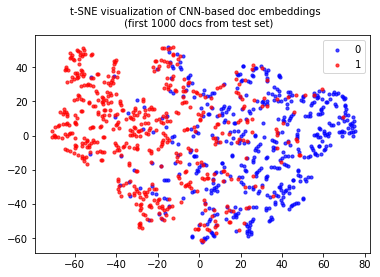

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras import backend as K

# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = K.function([model.layers[0].input,K.learning_phase()],
                               [model.layers[6].output])

n_plot = 1000
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(X_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

labels_plt = y_test[:n_plot,0].astype(np.int32)
my_colors = ['blue','red']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)

### Train the CNN

We train the model on CPU. Note you can get a significant speedup by using a GPU. We also add two callbacks:
* the first one ensures that training stops after `my_patience` epochs without improvement in test set accuracy (early stopping strategy)
* the second one (checkpointer) saves the model to disk for every epoch for which there is improvement. Therefore, at the end of training, the model saved on disk will be the one corresponding to the best epoch and we can reload it.

Use the [fit](https://keras.io/models/model/#methods) function of Keras to train the model.

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath=name_save,
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=0)

model.compile(my_optimizer, loss="binary_crossentropy")
model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping,checkpointer])

model.save(name_save)

Epoch 1/5
9595/9595 [==============================] - 20s 2ms/step - loss: 0.0299
Epoch 2/5
9595/9595 [==============================] - 21s 2ms/step - loss: 0.0112
Epoch 3/5
9595/9595 [==============================] - 20s 2ms/step - loss: 0.0056
Epoch 4/5
9595/9595 [==============================] - 24s 2ms/step - loss: 0.0040
Epoch 5/5
9595/9595 [==============================] - 22s 2ms/step - loss: 0.0043


We want to make sure we load the model corresponding to the best epoch.

In [28]:
from keras.models import load_model

try:
    model = load_model(name_save)
except Exception as e:
    print("No model saved")
    pass

### Visualization of document embeddings after training
We can see that after only a few epochs, our model has already learned meaningful internal representations:

In [ ]:
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(X_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)

plotting embeddings of first 1000 documents


### Saliency maps
Here we follow one of the approaches proposed in [Visualizing and Understanding Neural Models in NLP (Li et al., NAACL'16)](https://arxiv.org/abs/1506.01066).

The idea is to rank the elements of the input document based on their influence on the prediction. An approximation can be given by the magnitudes of the first-order partial derivatives of the output of the model with respect to each word in the input document. The interpretation is that we identify which words in the document need to be *changed the least to change the class score the most*. The derivatives can be obtained by performing a single back-propagation pass. Note that here, we backpropagate the class score and not the loss (like we do during training).

In [ ]:
input_tensors = [model.input, K.learning_phase()]
saliency_input = model.layers[1].output # before split into branches
saliency_output = model.layers[6].output # class score
gradients = model.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

for idx,doc in enumerate(X_test_my_idxs):
    matrix = compute_gradients([np.array([doc]),0])[0][0,:,:]
    tokens = [index_to_word[elt] for elt in doc if elt!=0]
    to_plot = np.absolute(matrix[:len(tokens),:])
    fig, ax = plt.subplots()
    heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
    fig.colorbar(heatmap)
    fig.set_size_inches(14,9)